## TODOS: 

TODO-2: create groups not on host families but on different ranks 

## Imports

### Import basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load in the dataframe

In [2]:
df = pd.read_pickle('./main_df.pkl')
print(df.shape)
df.head()

(2213180, 14)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


## Data preprocessing

### Get all of positive cases + the same number of negative cases randomly

In [3]:
# get all the positive cases
learning_df = df[df['y'] == 1]
# get the same amount of negative cases RANDOMLY
negative_learning_df = df[df['y'] == 0].sample(n=len(df[df['y'] == 1].index))

learning_df = pd.concat([learning_df, negative_learning_df], ignore_index=True)
print(learning_df.shape)
learning_df.head()

(33514, 14)


,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


### Groups dristribution

### Encode categorical values

*Note: encoding not needed because training is not based on virus and host names*

In [4]:
'''
transformed_data = pd.get_dummies(filled_df, columns=['virus', 'host'])
transformed_data
'''

"\ntransformed_data = pd.get_dummies(filled_df, columns=['virus', 'host'])\ntransformed_data\n"

### Extract X and y arrays

\+ get groups for LeaveOneGroupOut

In [4]:
# can also use .values for X and y for speed, but without it it's easier to look at these sets 
X = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y = learning_df['y']
groups = learning_df['group_code'].values

print(f'shape of X: {X.shape}')
print(f'len(y): {len(y)}')

shape of X: (33514, 9)
len(y): 33514


# Training using cross validation

### Using cross_validate function

In [5]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# determine the scoring method
scoring = ['f1']
# create logo cv procedure
logo = LeaveOneGroupOut()
# create model
model = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state=1)
# evaluate model
results = cross_validate(model, X, y, scoring=scoring, 
                        cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

In [6]:
model_small = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=1)
results_small = cross_validate(model_small, X, y, scoring=scoring, 
                        cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

## Get probabilities of class assignment for each element in main_df

for each estimator:
1. take the viruses from the test part of the estimator
2. for each of this virus estimate class for ALL the bacteria in main_df
3. check if estimation was correct
4. take best predictions (highest probabilities) for each virus
5. write these predictions down

### In main df:

Create X, y and groups sets for the main df

In [7]:
X_main = df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df['y']
groups_main = df['group_code'].values

Check if each subgroup contains all the hosts

In [9]:
hosts_num = len(pd.unique(df.loc[:, 'host']))
for i in range(0, max(groups_main)+1):
    if len(pd.unique(df.loc[groups_main == i, 'host'])) != hosts_num:
        print(f'ERROR: not enough hosts in subgroup {i} (hosts: {len(pd.unique(df.loc[groups_main == i, "host"]))})!')

Calculate the probabilities of classification for viruses in each of the test sets (i.e. where groups_main == i)

In [8]:
'''
prob_df_main = pd.DataFrame(index=range(len(df['y'])), columns=['0', '1'])
prob_df_main['0'] = prob_df_main['0'].astype('float')
prob_df_main['1'] = prob_df_main['1'].astype('float')
for i in range(0, max(groups_main)+1):
    mask_main = groups_main == i
    prob_df_main[mask_main] = \
        results['estimator'][i].predict_proba(X_main[mask_main])
'''

In [8]:
prob_df_main = pd.DataFrame(index=range(len(df['y'])), columns=['0', '1'])
prob_df_main['0'] = prob_df_main['0'].astype('float')
prob_df_main['1'] = prob_df_main['1'].astype('float')
for i in range(0, max(groups_main)+1):
    mask_main = groups_main == i
    prob_df_main.loc[mask_main, ['0', '1']] = \
        results['estimator'][i].predict_proba(X_main.loc[mask_main,:])

In [9]:
prob_df_main2 = pd.DataFrame(index=range(len(df['y'])), columns=['0', '1'])
prob_df_main2['0'] = prob_df_main2['0'].astype('float')
prob_df_main2['1'] = prob_df_main2['1'].astype('float')
for i in range(0, max(groups_main)+1):
    mask_main = groups_main == i
    prob_df_main2.loc[mask_main, ['0', '1']] = \
        results_small['estimator'][i].predict_proba(X_main.loc[mask_main,:])

Create a df with the results

In [10]:
df_all = pd.concat([df, prob_df_main], axis=1)
df_all2 = pd.concat([df, prob_df_main2], axis=1)

### Save all of this stuff to files

In [11]:
df_all.to_csv('test/df_all.tsv', sep='\t', index=False)
df_all2.to_csv('test/df_all_small.tsv', sep='\t', index=False)
learning_df.to_csv('test/learning_df.tsv', sep='\t', index=False)
from joblib import dump, load
dump(results, 'test/results.joblib')
dump(results_small, 'test/results_small.joblib')

['test/results_small.joblib']

Check if there indeed are all the expected predictions (2699 hosts for each virus)

In [13]:
hosts_num = len(pd.unique(df['host']))
for i, el in enumerate(df_all.groupby('virus')['host'].count()):
    if el != hosts_num:
        print(f'Error for virus {i}')

Determine if the predition was correct

In [15]:
df_all['estimator_correct'] = np.nan
df_all['estimator_correct'] = df_all['estimator_correct'].astype(bool)
mask = df_all['y'] == 0
df_all.loc[mask,'estimator_correct'] = df_all['0'] > df_all['1']
df_all.loc[mask, 'prob'] = df_all['0']
mask = df_all['y'] == 1
df_all.loc[mask, 'estimator_correct'] = df_all['1'] > df_all['0']
df_all.loc[mask, 'prob'] = df_all['1']
df_all['prob'] = df_all['prob'].astype('float')

In [38]:
correct_df = df_all[df_all['estimator_correct'] == True]
df_all

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1,estimator_correct,prob
6,NC_010363,NC_012438,57.2,0.0,0.009055,0.0,0.002532,0.515620,0.588794,0.0,-1.35836,Streptococcaceae,41,0,0.8,0.2,True,0.8
7,NC_010363,NC_006814,53.6,0.0,0.010561,0.0,0.001443,0.445837,0.412691,0.0,-1.34041,Streptococcaceae,41,0,1.0,0.0,True,1.0
8,NC_010363,NC_021181,53.6,0.0,0.010478,0.0,0.001445,0.445844,0.412664,0.0,-1.34044,Streptococcaceae,41,0,1.0,0.0,True,1.0
9,NC_010363,NC_021721,53.6,0.0,0.125869,0.0,0.003324,0.691869,0.655933,0.0,-1.37431,Streptococcaceae,41,0,1.0,0.0,True,1.0
10,NC_010363,NC_018420,53.6,0.0,0.047558,0.0,0.008447,0.441399,0.475200,0.0,-1.35649,Streptococcaceae,41,0,0.8,0.2,True,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213175,NC_024392,NC_009664,0.0,0.0,0.380006,0.0,0.006918,1.525475,1.535981,0.0,-1.46593,Listeriaceae,22,0,1.0,0.0,True,1.0
2213176,NC_024392,NC_011891,0.0,0.0,0.382821,0.0,0.010627,1.509128,1.523096,0.0,-1.47323,Listeriaceae,22,0,1.0,0.0,True,1.0
2213177,NC_024392,NC_015514,0.0,0.0,0.382899,0.0,0.007646,1.544129,1.575653,0.0,-1.45837,Listeriaceae,22,0,1.0,0.0,True,1.0
2213178,NC_024392,NC_011145,0.0,0.0,0.384063,0.0,0.010793,1.507242,1.526537,0.0,-1.47286,Listeriaceae,22,0,1.0,0.0,True,1.0


In [ ]:
df_all.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.823,0.177
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.642,0.358
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.787,0.213
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.828,0.172
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.790,0.210


# Scoring + visualisation

### ROC curve

In [ ]:
from sklearn.metrics import RocCurveDisplay
# Classification and ROC analysis
def draw_roc_cv(df_to_draw, est_name):
    # Run classifier with cross-validation and plot ROC curves
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(20, 20))
    for i, (train, test) in enumerate(logo.split(X_main, y_main, groups=groups_main)):
        viz = RocCurveDisplay.from_predictions(
            y_true=df_to_draw.loc[test, 'y'],
            y_pred=df_to_draw.loc[test, '1'],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"{est_name} - ROC curve",
    )
    ax.legend(loc="lower right")
    plt.show()

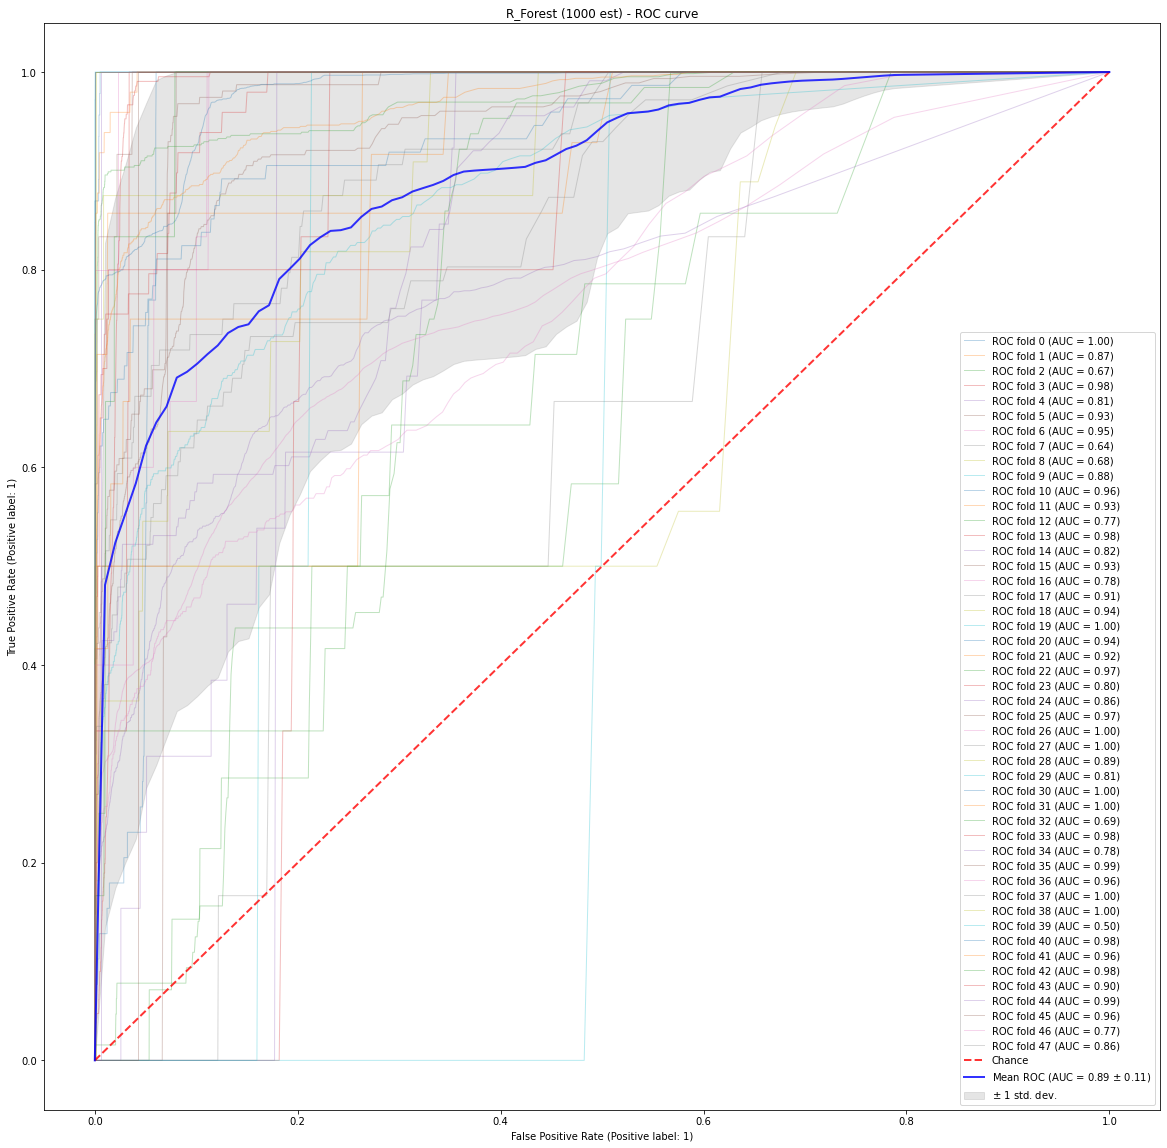

In [ ]:
draw_roc_cv(df_all, 'R_Forest (1000 est)')

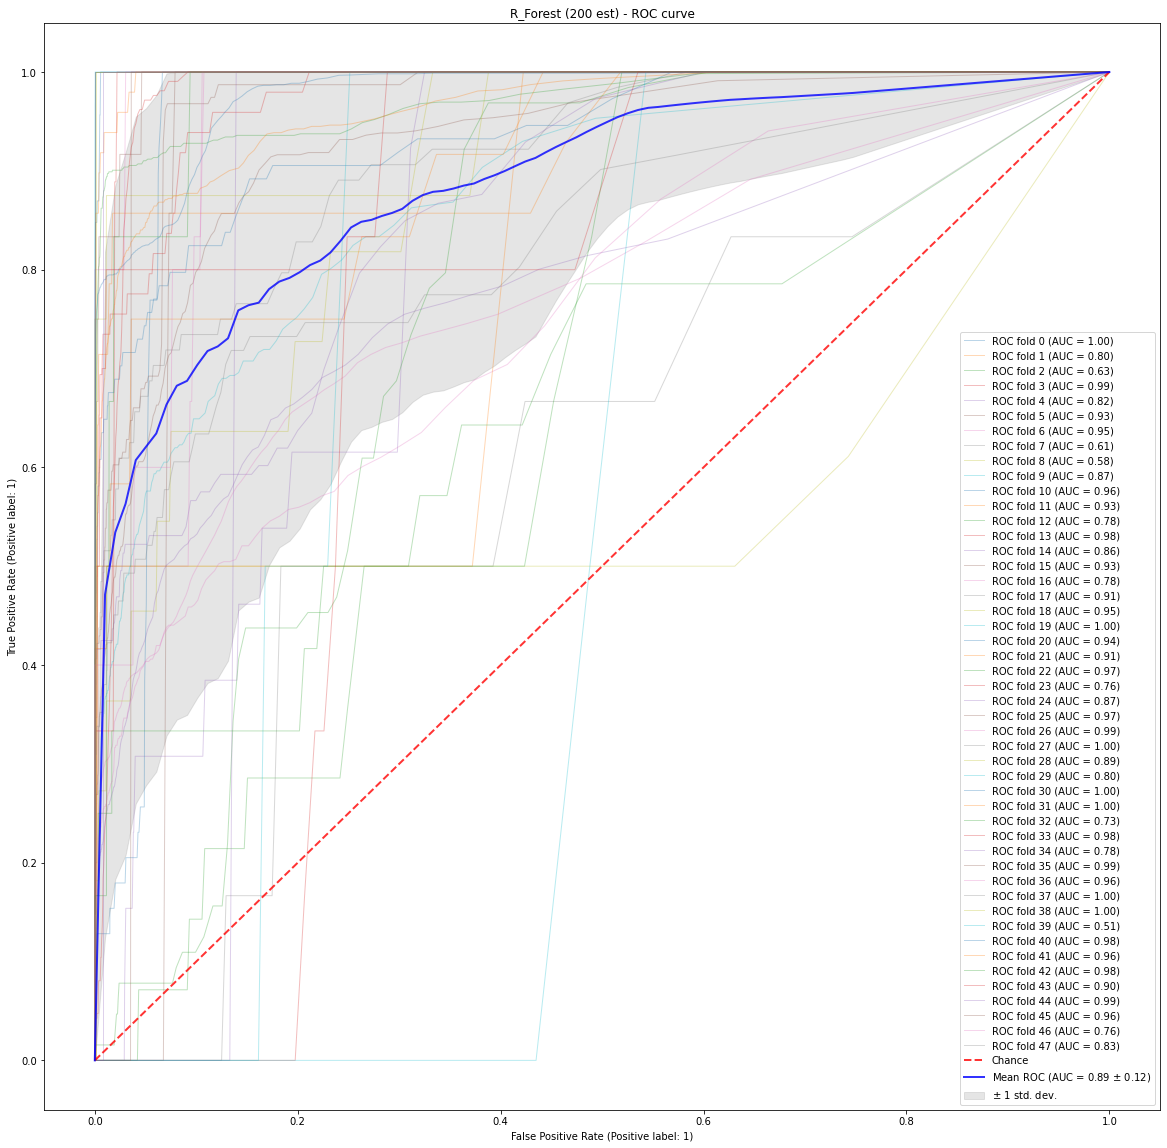

In [ ]:
draw_roc_cv(df_all2, 'R_Forest (200 est)')

### Precision - Recall curve

In [12]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve
precision, recall, thresholds = precision_recall_curve(df_all['y'], df_all['1'])
auc_large = auc(recall, precision)
precision_small, recall_small, thresholds_small = precision_recall_curve(df_all2['y'], df_all2['1'])
auc_small = auc(recall_small, precision_small)
fpr, tpr, thresh = roc_curve(df_all['y'], df_all['1'])

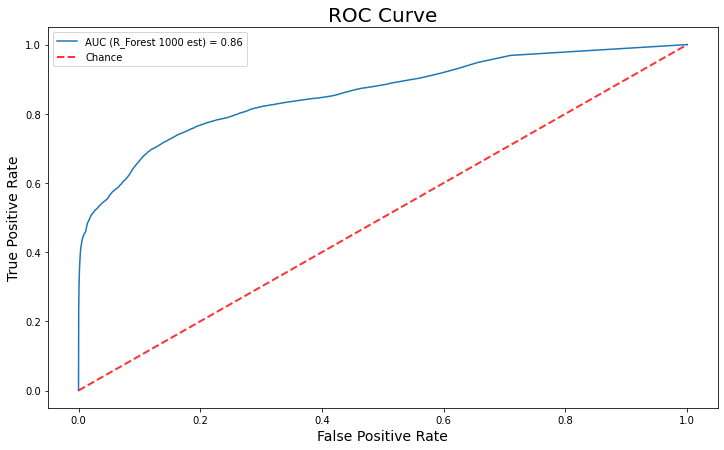

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, label=f'AUC (R_Forest 1000 est) = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

In [ ]:
f1_scores = 2*recall*precision/(recall+precision)
index = np.argmax(f1_scores)
print(f'Best threshold: {thresholds[index]} (index: {index})')
print('Best F1-Score: ', np.max(f1_scores))
print(f'best recall: {recall[index]}')
print(f'best precision: {precision[index]}')
print(f'F1 score: {2*recall[index]*precision[index]/(recall[index]+precision[index])}')

Best threshold: 0.901 (index: 901)
Best F1-Score:  0.44582624101156776


In [ ]:
f1_scores_small = 2*recall_small*precision_small/(recall_small+precision_small)
index_small = np.argmax(f1_scores_small)
print(f'Best threshold: {thresholds_small[index_small]} (index: {index_small})')
print('Best F1-Score: ', np.max(f1_scores_small))
print(f'best recall: {recall_small[index_small]}')
print(f'best precision: {precision_small[index_small]}')
print(f'F1 score: {2*recall_small[index_small]*precision_small[index_small]/(recall_small[index_small]+precision_small[index_small])}')

Best threshold: 0.91 (index: 182)
Best F1-Score:  0.4441489361702128
best recall: 0.3787074058602375
best precision: 0.5369320585497928
F1 score: 0.4441489361702128


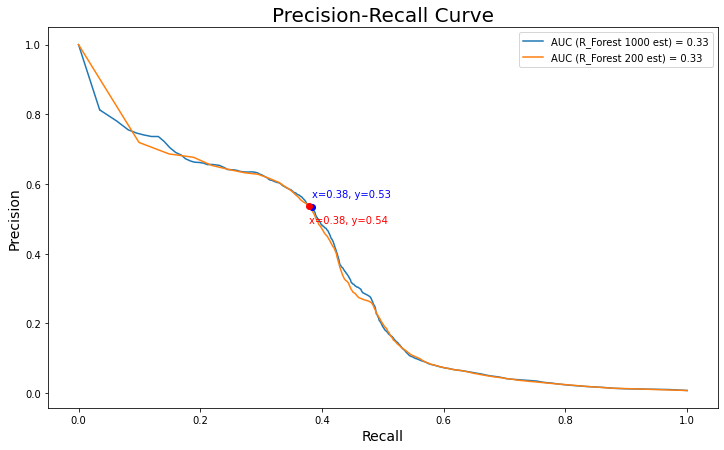

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(recall, precision, label=f'AUC (R_Forest 1000 est) = {auc_large:.2f}')
plt.plot(recall_small, precision_small, label=f'AUC (R_Forest 200 est) = {auc_small:.2f}')
plt.plot(recall[index], precision[index], 'bo')
plt.text(recall[index], precision[index]+0.03, f'x={recall[index]:.2f}, y={precision[index]:.2f}', color='blue')
plt.plot(recall_small[index_small], precision_small[index_small], 'ro')
plt.text(recall_small[index_small], precision_small[index_small]-0.05, f'x={recall_small[index_small]:.2f}, y={precision_small[index_small]:.2f}', color='red')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend()

In [51]:
condition = [np.greater_equal(df_all['1'], df_all['0'])]
output = [1]
# this means: check the condition and write output if true, else last arg
df_all['predicted'] = pd.Series(np.select(condition, output, 0))

In [47]:
condition = [np.greater_equal(df_all['1'], df_all['0'])]
output = [1]
preds = pd.Series(np.select(condition, output, 0))

In [50]:
(df_all['predicted'] == preds).all()

True

### Feature importance plots

#### Impurity-based feature importances (aka Gini importance)

In [39]:
importances = results['estimator'][0].feature_importances_
std = np.std([tree.feature_importances_ for tree in results['estimator'][0].estimators_], axis=0)

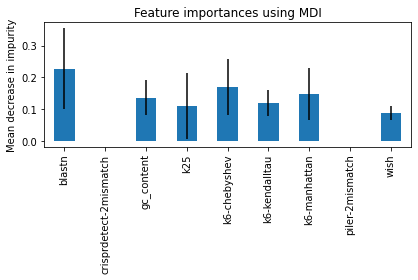

In [41]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature permutation-based feature importance

(better for features with high cardinality - many unique values)

In [42]:
from sklearn.inspection import permutation_importance

mask = df_all['group_code'] == 0
res = permutation_importance(
    estimator=results['estimator'][0], X=X_main[mask], y=y_main[mask], n_repeats=10, random_state=42, n_jobs=-1
)

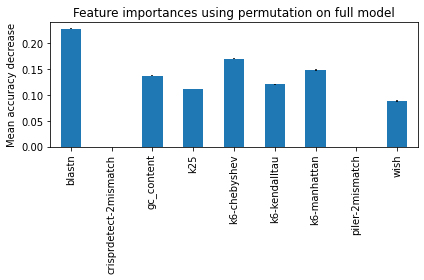

In [43]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=res.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### XAI methods

In [44]:
import dalex as dx

In [47]:
def predict_func(model, data):
    return model.predict(data)

mask = df_all['group_code'] != 0
explainer = dx.Explainer(results['estimator'][0], X_main[mask], y_main[mask], predict_function=predict_func)

Preparation of a new explainer is initiated

  -> data              : 2210481 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2210481 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_func at 0x000001A79492ACB0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


C:\Users\misia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  -> predicted values  : min = 0.0, mean = 0.0287, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.0211, max = 0.0
  -> model_info        : package sklearn

A new explainer has been created!


In [49]:
explainer.predict_parts(X_main[mask].iloc[500,:]).plot()

KeyboardInterrupt: 

# Determine best hosts for each virus - ones with the highest probabilities (and correct classification) 

Get indecies for the viruses with highest '1' values (for each virus)

In [39]:
# This means: groupby viruses, within these groups find rows with max values in '1' and return the indecies
mask = df_all.groupby('virus')['1'].transform(max) == df_all['1']
df_all[mask]

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1,estimator_correct,prob
229,NC_013599,NC_002488,4387.0,0.0,0.040827,2771.0,0.001057,0.441785,0.325658,0.0,-1.36647,Xanthomonadaceae,47,1,0.04,0.96,True,0.96
865,NC_008208,NC_018068,71.6,0.0,0.011028,0.0,0.001057,0.434584,0.309192,0.0,-1.37614,Aeromonadaceae,2,0,0.26,0.74,False,0.26
925,NC_021863,NC_009632,44528.0,0.0,0.024685,29811.0,0.001545,0.249551,0.269454,0.0,-1.30803,Staphylococcaceae,40,1,0.00,1.00,True,1.00
926,NC_021863,NC_009487,44528.0,0.0,0.024698,29811.0,0.001545,0.249531,0.269460,0.0,-1.30801,Staphylococcaceae,40,1,0.00,1.00,True,1.00
928,NC_021863,NC_022604,36169.0,0.0,0.025833,19424.0,0.001562,0.250328,0.271065,0.0,-1.32322,Staphylococcaceae,40,1,0.00,1.00,True,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177841,NC_024367,NC_022224,0.0,0.0,0.051724,0.0,0.001882,0.813859,0.620627,0.0,-1.40237,Rhodobacteraceae,36,0,0.06,0.94,False,0.06
2189549,NC_024379,NC_013203,0.0,0.0,0.042405,0.0,0.001567,0.757885,0.502093,0.0,-1.40202,Enterobacteriaceae,16,0,0.44,0.56,False,0.44
2193011,NC_024381,NC_010801,0.0,0.0,0.123494,0.0,0.004315,0.785231,0.872633,0.0,-1.38766,Pseudomonadaceae,34,0,0.65,0.35,True,0.65
2193012,NC_024381,NC_010087,0.0,0.0,0.123494,0.0,0.004315,0.785229,0.872643,0.0,-1.38871,Pseudomonadaceae,34,0,0.65,0.35,True,0.65


In [40]:
df_1 = df_all.loc[mask, ['virus', 'host', '1']]
df_1

,virus,host,1
229,NC_013599,NC_002488,0.96
865,NC_008208,NC_018068,0.74
925,NC_021863,NC_009632,1.00
926,NC_021863,NC_009487,1.00
928,NC_021863,NC_022604,1.00
...,...,...,...
2177841,NC_024367,NC_022224,0.94
2189549,NC_024379,NC_013203,0.56
2193011,NC_024381,NC_010801,0.35
2193012,NC_024381,NC_010087,0.35


### Write down the classification results

Load in the taxonomy JSONs

In [41]:
import json
import pathlib

orgs = {}
for file in pathlib.Path('./taxonomy/').iterdir():
    with open(file, 'r') as open_file:
        orgs[file.stem] = json.load(open_file)
        
orgs.keys()

dict_keys(['host', 'virus'])

Get the names of viruses and hosts

In [42]:
df_1['virus_name'] = df_1.apply(lambda row: orgs["virus"][row['virus']]["organism_name"].split(",")[0], axis=1)
df_1['host_name'] = df_1.apply(lambda row: orgs["host"][row['host']]["organism_name"], axis=1)

In [43]:
# reorder columns
df_1 = df_1[['virus', 'virus_name', 'host', 'host_name', '1']]

Sort the dataframe - for looking for differences later

In [44]:
df_1 = df_1.sort_values(by=['virus', 'host'])

Write result to file

In [43]:
df_1.to_csv('all_bacteria_with_highest_1_prob_log.tsv', sep='\t', index=False)

### Check if estimator predicted correct host species, genus, family, order ... 

Get 1 host for each virus (group)

In [45]:
df_chosen = df_1.groupby('virus').apply(pd.DataFrame.sample, 
                    n=1, axis=0).reset_index(drop=True)
df_chosen

,virus,virus_name,host,host_name,1
0,NC_000866,Enterobacteria phage T4,NC_016612,Klebsiella oxytoca KCTC 1686,0.93
1,NC_000871,Streptococcus phage Sfi19,NC_017595,Streptococcus salivarius JIM8777,0.99
2,NC_000872,Streptococcus phage Sfi21,NC_017563,Streptococcus thermophilus ND03,1.00
3,NC_000896,Lactobacillus prophage phiadh,NC_005362,Lactobacillus johnsonii NCC 533,0.94
4,NC_000902,Enterobacteria phage VT2-Sakai,NC_020163,Escherichia coli APEC O78,1.00
...,...,...,...,...,...
815,NC_024387,Listeria phage LP-101,NC_021830,Listeria monocytogenes J1-220,1.00
816,NC_024388,Leuconostoc phage phiLN34,NC_008531,Leuconostoc mesenteroides subsp. mesenteroides...,0.73
817,NC_024389,Leuconostoc phage phiLNTR2,NC_008531,Leuconostoc mesenteroides subsp. mesenteroides...,0.93
818,NC_024391,Staphylococcus phage DW2,NC_002951,Staphylococcus aureus subsp. aureus COL,1.00


Determine if the chosen bacteria is a correct prediction at a given taxonomic rank

In [46]:
def lookup_taxonomy(x, rank):
    rank_idx = orgs['host'][x['host']]['lineage_ranks'].index(rank)
    return 1 if orgs["host"][x['host']]["lineage_names"][rank_idx] == \
        orgs['virus'][x['virus']]['host']['lineage_names'][rank_idx] else 0

ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']
for rank in ranks:
    df_chosen[f'{rank}_correct'] = df_chosen.apply(lookup_taxonomy, rank=rank, axis=1)

In [48]:
df_chosen.to_csv('1_bac_per_vir_log.tsv', sep='\t', index=False)

In [ ]:
df_chosen[f"{rank}_correct"].sum() / len(df_chosen.index)*100

Calculate percentage of correct predictions on all taxonomic levels

In [49]:
# the log will contain a commented summary at the top
with open('1_bac_per_vir_log.tsv', mode='r+') as of:
    to_write = '# Prediction summary:\n'
    content = of.read()
    of.seek(0, 0)
    for rank in ranks:
        to_write += (f'# {rank}: {df_chosen[f"{rank}_correct"].sum() / len(df_chosen.index)*100:.2f}% correct\n')
    of.write(to_write + content)

In [46]:
df_chosen[df_chosen['1'] != 1]

,virus,virus_name,host,host_name,1,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
8,NC_001330,Enterobacteria phage alpha3,NC_022513,Ralstonia pickettii DTP0602 chromosome 1,0.9,0,0,0,0,0,1,1
9,NC_001331,Pseudomonas phage Pf1,NC_023066,Pseudomonas aeruginosa LES431,0.9,1,1,1,1,1,1,1
10,NC_001332,Enterobacteria phage I2-2,NC_015722,Candidatus Midichloria mitochondrii IricVA,0.9,0,0,0,0,0,1,1
11,NC_001341,Acholeplasma phage MV-L1,NC_020304,Desulfocapsa sulfexigens DSM 10523,0.7,0,0,0,0,0,0,1
14,NC_001417,Enterobacterio phage MS2,NC_020133,Mycobacterium liflandii 128FXT,0.8,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
810,NC_024379,Escherichia phage PE3-1,NC_012892,Escherichia coli BL21(DE3),0.8,1,1,1,1,1,1,1
811,NC_024381,Pseudomonas phage vB_PaeS_SCH_Ab26,NC_007510,Burkholderia sp. 383 chromosome 1,0.7,0,0,0,0,0,1,1
812,NC_024383,Listeria phage LP-083-2,NC_017728,Listeria monocytogenes 07PF0776,0.9,1,1,1,1,1,1,1
816,NC_024388,Leuconostoc phage phiLN34,NC_017312,Enterococcus faecalis 62,0.8,0,0,0,1,1,1,1


In [52]:
df_chosen['1'].describe()

count    820.000000
mean       0.923659
std        0.120950
min        0.300000
25%        0.900000
50%        1.000000
75%        1.000000
max        1.000000
Name: 1, dtype: float64

In [56]:
df_test = pd.read_csv('1_bac_per_vir_log.tsv', sep='\t', comment='#')

# Additional/old code

Explicit tqdm handling (better visualisaition)

*Watch out -* ***long!***

*This code is for LeaveOneOut* ***only!***

In [ ]:
'''
# FOR LEAVE ONE OUT ONLY!
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# enumerate splits
y_true, y_pred = list(), list()
pbar = tqdm(total=len(X))

for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # fit model
    model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
    pbar.update(1)
pbar.close()
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc:.3f}')
'''

### Is the prediction replicable + does it work the way it's supposed to?

In [ ]:
'''
idx = learning_df[learning_df['group_code'] == 0].index
X_ref_train = learning_df.drop(index=idx).drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1).values
X_ref_test = learning_df.iloc[idx,:].drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1).values
y_ref_train = learning_df.drop(index=idx).iloc[:, -1]
y_ref_test = learning_df.iloc[idx,-1]
'''

In [ ]:
'''
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=1)
model.fit(X_ref_train, y_ref_train)
y_pred = model.predict(X_ref_test)
'''

In [ ]:
'''
from sklearn.metrics import f1_score
print(f'F1 is: {f1_score(y_ref_test, y_pred)}')
'''

Determining most certain class 1 predictions done with a dict

In [ ]:
# determining most certain class 1 predictions done with a dict
'''
# define the function
def write_down(x):
    if x['virus'] not in best_hosts.keys(): 
        best_hosts[x['virus']] = {} 
        best_hosts[x['virus']]['hosts'] = []
    best_hosts[x['virus']]['hosts'].append((x['host'], x['1']))

# apply the function
best_hosts = {}
best_hosts_df = pd.DataFrame(columns=['virus', 'host', 'prob'])
_ = df_all[mask].apply(write_down, axis=1)
del _

# write down the results to file 
with open('host_predictions_1_based_log.tsv', 'w') as of:
    of.write('virus\tvirus_name\thost\thost_name\t1\n')
    for key, val in best_hosts.items():
        for el in val["hosts"]:
            of.write(f'{key}\t{orgs["virus"][key]["organism_name"].split(",")[0]}\t{el[0]}\t{orgs["host"][el[0]]["organism_name"]}\t{el[1]}\n')
'''

Old version just to check if both return the same things

In [ ]:
# Old version of getting the max subgroups - inefficient
'''
# WATCH OUT - long (approx. 3 min.)
viruses = pd.unique(df_all['virus'])
best_hosts = {}
# best_hosts_df = pd.DataFrame(columns=['virus', 'host', '1'])

for vir in viruses:
    best_hosts[vir] = {}
    best_hosts[vir]['hosts'] = []
    mask = df_all['virus'] == vir
    vir_max_prob = max(df_all[mask]['1'])

    # best_hosts_df = pd.concat([best_hosts_df, correct_df.loc[
    #         (mask) & 
    #         (correct_df['prob'] == vir_max_prob),  
    #         ['virus', 'host', 'prob']]])

    for _, row in df_all.loc[(mask) & (df_all['1'] == vir_max_prob),].iterrows():
        best_hosts[vir]['hosts'].append((row['host'], row['1']))

# writing down the results
with open('2_log_test.tsv', 'w') as of:
    of.write('virus\tvirus_name\thost\thost_name\t1\n')
    for key, val in best_hosts.items():
        for el in val["hosts"]:
            of.write(f'{key}\t{orgs["virus"][key]["organism_name"].split(",")[0]}\t{el[0]}\t{orgs["host"][el[0]]["organism_name"]}\t{el[1]}\n')
'''


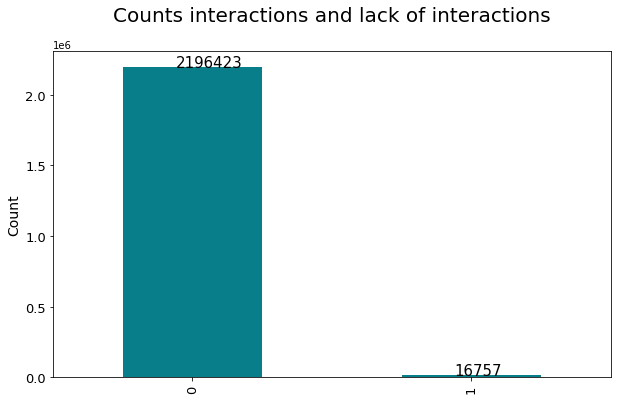

In [ ]:
'''
ax = df_all['y'].value_counts().plot(kind='bar', figsize=(10,6), fontsize=13, color='#087E8B')
ax.set_title('Counts interactions and lack of interactions', size=20, pad=30)
ax.set_ylabel('Count', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 100, str(round(i.get_height(), 2)), fontsize=15)
'''